## Hyperparameter Tuning with Keras Tuner

---

Created for Coursera guided project [Hyperparameter Tuning with Keras Tuner](https://www.coursera.org/learn/keras-tuner)

---

In [1]:
!pip install keras-tuner

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


C:\Users\Atakan\anaconda3\envs\my_rl_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


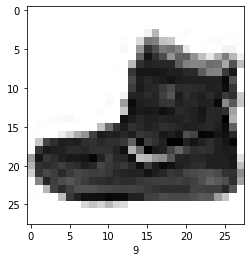

In [4]:
plt.imshow(x_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [5]:
x_train.shape

(60000, 28, 28)

In [28]:
def create_model(hp):
    if hp:
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        num_units = hp.Choice('num_units', values=[8, 16, 32])
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1)
        num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    else:
        dropout_rate = 0.1
        num_units = 8
        learning_rate = 1e-4
        num_hidden_layers = 1
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Lambda(lambda x: x/255.))
    
    for _ in range(0, num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(float(learning_rate)),
        metrics=['accuracy']
    )
    
    return model

In [29]:
create_model(None).summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 6280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [30]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
        super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [31]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True,
)

In [32]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': None}
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}


In [33]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

INFO:tensorflow:Oracle triggered exit


In [35]:
tuner.results_summary(1)

Results summary
Results in logs\fashion_mnist
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_rate: 0.5
num_units: 32
learning_rate: 0.0001
num_hidden_layers: 1
batch_size: 32
Score: 0.8197000026702881


In [36]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [37]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=2,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
1875/1875 - 1s - loss: 0.6666 - accuracy: 0.7657 - val_loss: 0.5035 - val_accuracy: 0.8197
Epoch 2/20
1875/1875 - 1s - loss: 0.6425 - accuracy: 0.7745 - val_loss: 0.4912 - val_accuracy: 0.8293
Epoch 3/20
1875/1875 - 1s - loss: 0.6303 - accuracy: 0.7793 - val_loss: 0.4826 - val_accuracy: 0.8307
Epoch 4/20
1875/1875 - 1s - loss: 0.6171 - accuracy: 0.7831 - val_loss: 0.4768 - val_accuracy: 0.8321
Epoch 5/20
1875/1875 - 1s - loss: 0.6044 - accuracy: 0.7873 - val_loss: 0.4695 - val_accuracy: 0.8308
Epoch 6/20
1875/1875 - 1s - loss: 0.5983 - accuracy: 0.7895 - val_loss: 0.4622 - val_accuracy: 0.8355
Epoch 7/20
1875/1875 - 1s - loss: 0.5900 - accuracy: 0.7937 - val_loss: 0.4581 - val_accuracy: 0.8374
Epoch 8/20
1875/1875 - 1s - loss: 0.5830 - accuracy: 0.7951 - val_loss: 0.4549 - val_accuracy: 0.8393
Epoch 9/20
1875/1875 - 1s - loss: 0.5803 - accuracy: 0.7958 - val_loss: 0.4483 - val_accuracy: 0.8406
Epoch 10/20
1875/1875 - 1s - loss: 0.5708 - accuracy: 0.7994 - val_loss: 0.4473 - 

In [38]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 523us/step - loss: 0.4255 - accuracy: 0.8486


[0.42548730969429016, 0.8485999703407288]